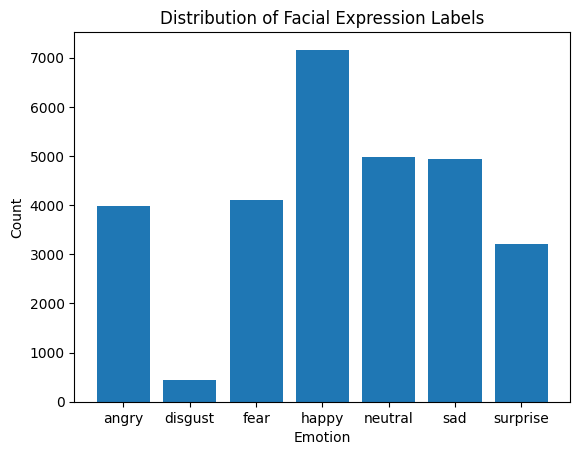

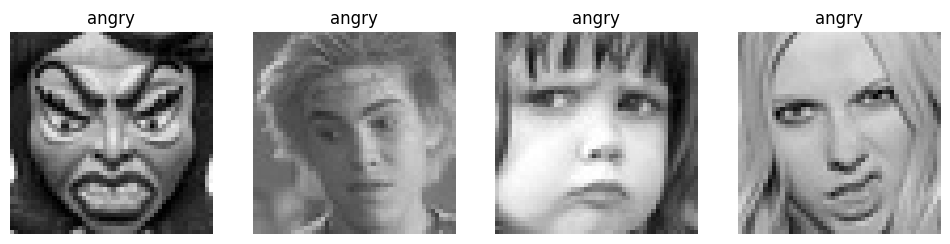

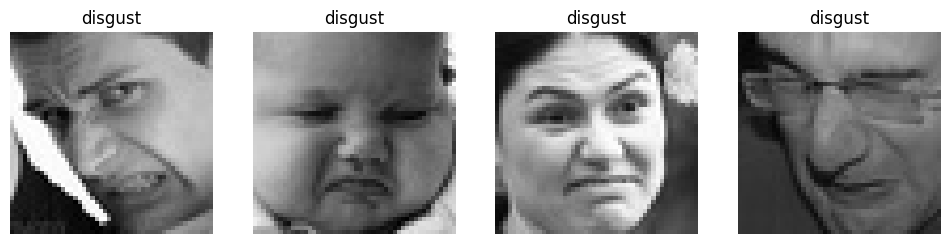

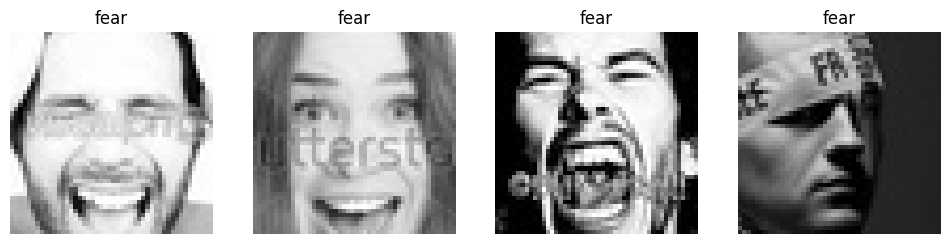

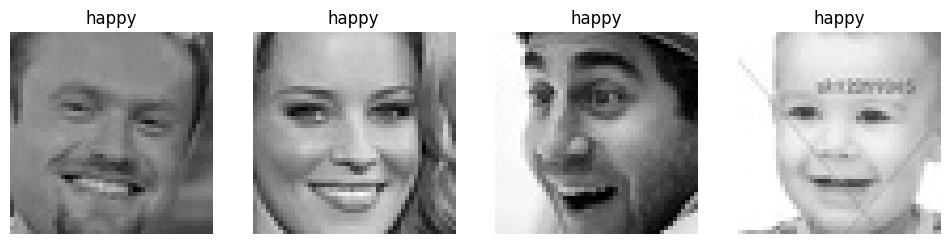

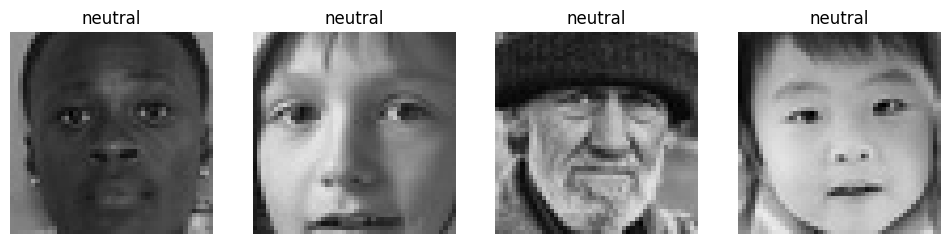

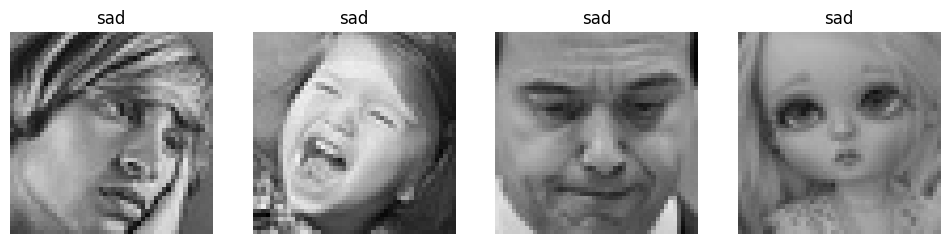

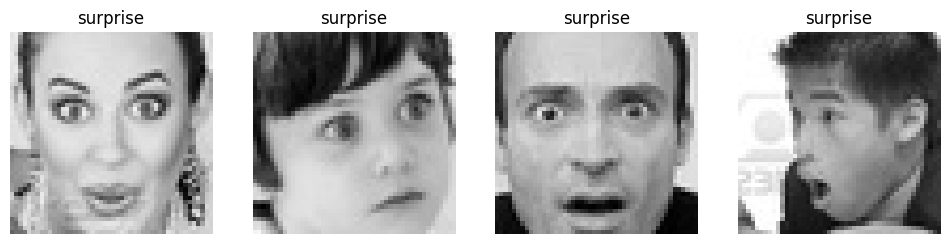

In [1]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Define the path to the dataset
dataset_path = 'images/images'

# Get the list of emotion classes
emotions = os.listdir(os.path.join(dataset_path, 'train'))

# Visualize the distribution of facial expression labels
emotion_counts = {emotion: len(os.listdir(os.path.join(dataset_path, 'train', emotion))) for emotion in emotions}
plt.bar(emotion_counts.keys(), emotion_counts.values())
plt.title('Distribution of Facial Expression Labels')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

# Display 4 random images from each expression class
num_images_to_display = 4

for emotion in emotions:
    emotion_path = os.path.join(dataset_path, 'train', emotion)
    image_files = os.listdir(emotion_path)
    random_images = random.sample(image_files, num_images_to_display)
    
    plt.figure(figsize=(12, 3))
    for i, image_file in enumerate(random_images):
        image = cv2.imread(os.path.join(emotion_path, image_file))
        plt.subplot(1, num_images_to_display, i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(emotion)
        plt.axis('off')
    plt.show()


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


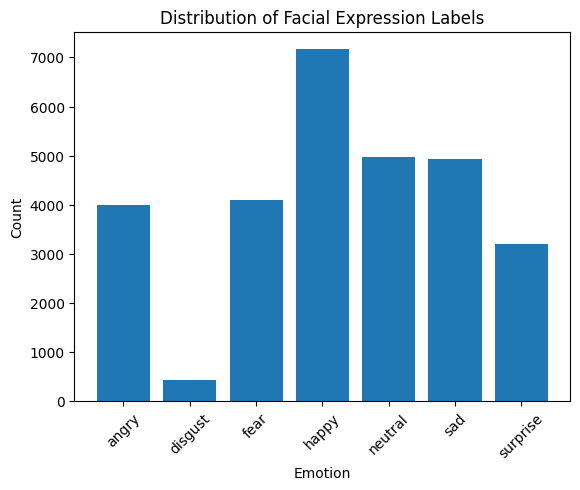

221/221 [==============================] - 10s 41ms/step


ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

In [2]:
import os
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import RandomizedSearchCV

# Set the data directory
data_dir = 'images/images/'

# Data Preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(data_dir, 'validation'),
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical'
)

# Visualize the distribution of facial expression labels
import matplotlib.pyplot as plt

label_names = train_generator.class_indices.keys()
label_counts = [np.sum(train_generator.classes == i) for i in range(len(label_names))]

plt.bar(label_names, label_counts)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Facial Expression Labels')
plt.xticks(rotation=45)
plt.show()

# Model Hyperparameter Optimization using Random Search
from sklearn.model_selection import RandomizedSearchCV

def create_model(optimizer='adam', activation='relu', dropout_rate=0.3):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation=activation, input_shape=(48, 48, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation=activation),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation=activation),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=activation),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(7, activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

param_dist = {
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'activation': ['relu', 'tanh', 'sigmoid'],
    'dropout_rate': [0.2, 0.3, 0.4]
}

# Perform hyperparameter tuning without KerasClassifier
best_accuracy = 0
best_params = None
for _ in range(10):  # Randomized search
    params = {key: np.random.choice(values) for key, values in param_dist.items()}
    model = create_model(optimizer=params['optimizer'], activation=params['activation'], dropout_rate=params['dropout_rate'])
    model.fit(train_generator, validation_data=validation_generator, epochs=10, verbose=0)
    validation_labels = validation_generator.classes
    validation_predictions = model.predict(validation_generator)
    accuracy = accuracy_score(validation_labels, validation_predictions)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

print("Best Hyperparameters:", best_params)

# Build and train the CNN model with the best hyperparameters
model = create_model(optimizer=best_params['optimizer'], activation=best_params['activation'], dropout_rate=best_params['dropout_rate'])

model.fit(train_generator, validation_data=validation_generator, epochs=10)

# Evaluate model performance

# Evaluate model performance and calculate accuracy
validation_labels = validation_generator.classes
validation_predictions = model.predict(validation_generator)
predicted_labels = np.argmax(validation_predictions, axis=1)  # Convert probabilities to class labels

accuracy = accuracy_score(validation_labels, predicted_labels)
classification_rep = classification_report(validation_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)


# Display 4 random images from each expression class
num_images_to_display = 4

for emotion in emotions:
    emotion_path = os.path.join(dataset_path, 'train', emotion)
    image_files = os.listdir(emotion_path)
    random_images = random.sample(image_files, num_images_to_display)
    
    plt.figure(figsize=(12, 3))
    for i, image_file in enumerate(random_images):
        image = cv2.imread(os.path.join(emotion_path, image_file))
        plt.subplot(1, num_images_to_display, i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(emotion)
        plt.axis('off')
    plt.show()

# Implement techniques for dealing with class imbalance (e.g., weighted loss)
class_weights = {}
for i, label in enumerate(label_names):
    class_weights[i] = len(train_generator.classes) / (len(label_names) * np.bincount(train_generator.classes)[i])

# Train the model with weighted loss
model.fit(train_generator, validation_data=validation_generator, epochs=10, class_weight=class_weights)
